In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from tqdm import tqdm
import seaborn as sns

import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import pandas as pd
from scipy.optimize import fsolve

N = 20001

#fname = f'Jaffe_{N-1}_eps_0.01_out_perturber_Mp_0.03.txt'
fname = f'Jaffe_{N-1}_eps_0.01_out_perturber.txt'

In [2]:
G = 1 

# Masse
M   = 1 
M_p = M / 10
m   = M / N

# Raggi
Rs   = 1 

# Rho0
rho_0 = M / (4 * np.pi * (Rs)**3)

In [3]:
data = pd.read_csv(fname, names=list(range(7)), sep = ' ')
datas = np.array(data)

In [4]:
def dati (data,N,M_tot,M_p):

    x = []
    y = []
    z = []
    
    v_x = []
    v_y = []
    v_z = []
    
    start = N + 3
    step  = N * 3 + 3
    
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    
    b = (np.array([data.iloc[i::step,:].copy() for i in range(start+N,start+(N)*2)]))
    
    for j in range(len(b)):
        temp = np.array([b[j][i][~np.isnan(b[j][i])] for i in range(len(b[j]))])
        
        v_x.append(temp[:,0])
        v_y.append(temp[:,1])
        v_z.append(temp[:,2])
     

    v_x = np.array(v_x)
    v_y = np.array(v_y)
    v_z = np.array(v_z)
    
    #cm
    cm_x = []
    cm_y = []
    cm_z = []
    
    # Centro di Massa del sistema di 20000 particelle uso mean e median
    cm_x.append(np.median(x[1:], axis=0))
    cm_y.append(np.median(y[1:], axis=0))
    cm_z.append(np.median(z[1:], axis=0))

    cm_x = np.array(cm_x[0])
    cm_y = np.array(cm_y[0])
    cm_z = np.array(cm_z[0])

    print('The initial center of mass is (', cm_x[0],', ', cm_y[0],', ', cm_z[0], ')')  
    print('The final center of mass is (', cm_x[-1],', ', cm_y[-1],', ', cm_z[-1], ')')
            
    cm_v_x = []
    cm_v_y = []
    cm_v_z = []        
        
    # Velocità del centro di massa Jaffe
    cm_v_x.append(np.median(v_x[1:], axis=0))
    cm_v_y.append(np.median(v_y[1:], axis=0))
    cm_v_z.append(np.median(v_z[1:], axis=0))

    cm_v_x = np.array(cm_v_x[0])
    cm_v_y = np.array(cm_v_y[0])
    cm_v_z = np.array(cm_v_z[0])
        
    
    r    = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    cm_r = np.array([(cm_x[i]**2+cm_y[i]**2+cm_z[i]**2)**0.5 for i in range(len(cm_x))])
    
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]
    
    return x,y,z,cm_x, cm_y, cm_z,v_x,v_y,v_z,cm_v_x,cm_v_y,cm_v_z,r,cm_r,t

In [5]:
x,y,z,cm_x,cm_y,cm_z,v_x,v_y,v_z,cm_vx,cm_vy,cm_vz,r,r_cm,time = dati(data, N, M, M_p)

The initial center of mass is ( -0.00087059336 ,  0.000648987425 ,  -0.00029512617 )
The final center of mass is ( 0.13879572 ,  1.66226775 ,  0.0521084725 )


In [6]:
x      = x[:, :200]
y      = y[:, :200]
z      = z[:, :200]
cm_x   = cm_x[:200]
cm_y   = cm_y[:200]
cm_z   = cm_z[:200]
v_x    = v_x[:, :200]
v_y    = v_y[:, :200]
v_z    = v_z[:, :200]
cm_vx  = cm_vx[:200]
cm_vy  = cm_vy[:200]
cm_vz  = cm_vz[:200]
r      = r[:, :200]
r_cm   = r_cm[:200]
time   = time[:200]

In [7]:
perturber_position = np.matrix(np.empty((len(time), 3)))
perturber_velocity = np.matrix(np.empty((len(time), 3)))

for i in range(len(time)):
    # Posizioni sono in kpc
    perturber_position[i, 0] = x[0][i] - cm_x[i]
    perturber_position[i, 1] = y[0][i] - cm_y[i]
    perturber_position[i, 2] = z[0][i] - cm_z[i]

    #Velocità sono in cm/s
    perturber_velocity[i, 0] = v_x[0][i] - cm_vx[i]
    perturber_velocity[i, 1] = v_y[0][i] - cm_vy[i]
    perturber_velocity[i, 2] = v_z[0][i] - cm_vz[i]

In [8]:
distance = np.sqrt((cm_x - x[0])**2 + (cm_y - y[0])**2 + (cm_z - z[0])**2)

### Apo e peri

In [9]:
def Jaffe_pot(radii, Rs, M, G):
    return ((M * G) / Rs) * np.log(radii/(radii+Rs)) 

def V_cent(radii, position, velocity, Rs, M_p, G):
    mp_v = M_p * velocity                                               
    L0 = np.cross(position, mp_v)                                        
    L02 = np.linalg.norm(L0)**2

    return L02/(2 * M_p * radii**2)

def Phi_eff(radii, position, velocity, Rs, M, M_p, G):
    return Jaffe_pot(radii, Rs, M, G) + V_cent(radii, position, velocity, Rs, M_p, G)

In [10]:
velocities = np.sqrt(v_x**2 + v_y**2 + v_z**2)

In [11]:
eccentricita_2 = np.zeros(len(time))
ecc_rays       = np.linspace(1e-8, 10, 100000)
r_peri = np.zeros(len(time))
r_apo = np.zeros(len(time))

for i in tqdm(range(0, len(time))):
    E_p = (1/2) * M_p * velocities[0][i]**2 + Jaffe_pot(distance[i], Rs, M, G)
    equation = Phi_eff(ecc_rays,perturber_position[i].A[0], perturber_velocity[i].A[0],Rs, M, M_p, G) - E_p
    solutions = []
    for j in range(1, len(equation)):
        if equation[j-1]*equation[j] < 0:
            solutions.append((ecc_rays[j-1]+ecc_rays[j])/2)
    
    r_peri[i] = np.min(solutions)
    r_apo[i] =  np.max(solutions)

    eccentricita_2[i] = (r_apo[i] - r_peri[i])/(r_apo[i] + r_peri[i])
    

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.19it/s]


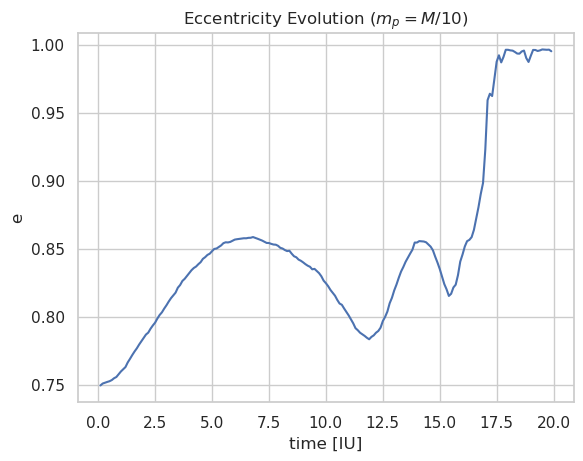

In [12]:
sns.set(style='whitegrid')
plt.plot(time[1:], eccentricita_2[1:])
plt.xlabel('time [IU]')
plt.ylabel('e')
plt.title(r'Eccentricity Evolution ($m_p = M/10$)')
plt.savefig('Results/Eccentricity M10.png')

(173, 0.01304824133375762)

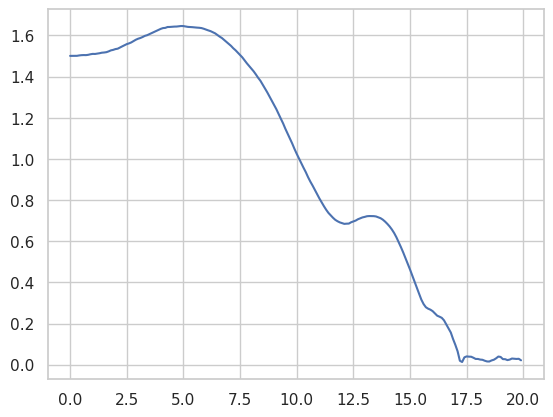

In [13]:
plt.plot(time, distance)
np.argmin(distance), np.min(distance)

In [14]:
for i in range(len(eccentricita_2)):
    print( eccentricita_2[i])

0.749985418245667
0.7495920658556575
0.7510061154739155
0.7516038638563356
0.7521850512506988
0.7527075724618604
0.7535514583891021
0.7549105233443727
0.7557976837689065
0.7578174953961462
0.7598718606888263
0.7614716254275086
0.7631179948331347
0.7665421780075328
0.769190378334313
0.7719974219420832
0.774591112446456
0.7769284539978913
0.7796738406561904
0.7821453437906183
0.784517845940328
0.7870273323208906
0.7884202495978144
0.7912806763400559
0.7936553704651862
0.7957454076359108
0.798767129867967
0.8014041456937776
0.8033398278052128
0.8060914775739002
0.8085519829812623
0.8113110447151907
0.8137903408944657
0.8158074335290854
0.8178353998995938
0.8214813038569455
0.8234259691047335
0.8264341035571002
0.827995245687319
0.8300907818182768
0.8322540589870406
0.8343364928353697
0.8359594728649284
0.8370224625054596
0.8387513966395612
0.8402273528029833
0.8426833294730776
0.8439296489243466
0.845577032806353
0.8464704460254625
0.8483034963214021
0.8499971612064884
0.8502919239240019


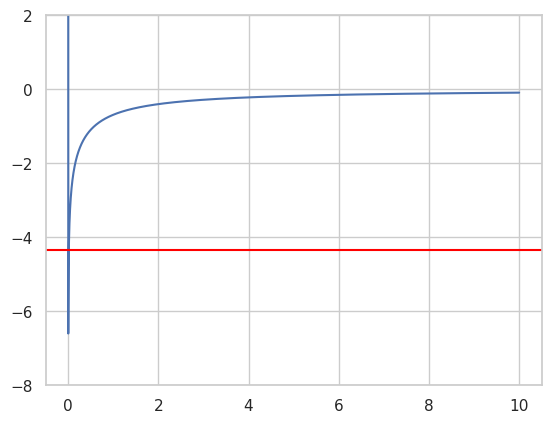

In [15]:
i = 173
plt.plot(ecc_rays, Phi_eff(ecc_rays, perturber_position[i].A[0], perturber_velocity[i].A[0],Rs, M,  M_p, G))
#plt.axvline(x = r_apo[i], color='green')
#plt.axvline(x = r_peri[i], color='green')
plt.ylim(-8, 2)
#plt.xlim(-0.001, 1)
plt.axhline(y = 0.5 * M_p * velocities[0][i]**2 + Jaffe_pot(distance[i], Rs, M, G), color='red')